In [1]:
include("main.jl")
using PyCall
using CairoMakie
sepsis_gym = pyimport("custom_sepsis")
using Statistics


/Users/luisastue/miniconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
ts100 = Dict(
    :Simple100 => [sepsis_gym.DirThompsonSampling.load_json("json/dirichlet/ts/Simple-$i.json") for i in 0:2],
    :Medium100 => [sepsis_gym.DirThompsonSampling.load_json("json/dirichlet/ts/Medium-$i.json") for i in 0:2],
    :None100 => [sepsis_gym.DirThompsonSampling.load_json("json/dirichlet/ts/None-$i.json") for i in 0:2],
    :Softmax100 => [load_jld("data/mcmc/runs/SoftmaxPPL-$i.jld")  for i in 1:3],
    :SimplePPL100 => [load_jld("data/mcmc/runs/SimplePPL-$i.jld")  for i in 1:3],
)

Dict{Symbol, Vector} with 5 entries:
  :SimplePPL100 => RunData[RunData("SimplePPL-1", :SimplePPL, ModelData(Dynamic…
  :Medium100    => PyObject[PyObject <custom_sepsis.models.dirichlet.evaluate.t…
  :Simple100    => PyObject[PyObject <custom_sepsis.models.dirichlet.evaluate.t…
  :None100      => PyObject[PyObject <custom_sepsis.models.dirichlet.evaluate.t…
  :Softmax100   => RunData[RunData("SoftmaxPPL-1", :Softmax, ModelData(DynamicC…

In [3]:
ts1 = Dict(
    :Simple1 => [sepsis_gym.DirThompsonSampling.load_json("json/dirichlet/ts/Simple-every-$i.json") for i in 1:3],
    :Medium1 => [sepsis_gym.DirThompsonSampling.load_json("json/dirichlet/ts/Medium-every-$i.json") for i in 1:3],
    :Softmax1 => [load_jld("data/mcmc/runs/SoftmaxPPL-every-$i.jld")  for i in 1:3],
    :SimplePPL1 => [load_jld("data/mcmc/runs/SimplePPL-every-$i.jld")  for i in 1:3]
)

Dict{Symbol, Vector} with 4 entries:
  :Softmax1   => RunData[RunData("SoftmaxPPL-every-1", :Softmax, ModelData(Dyna…
  :SimplePPL1 => RunData[RunData("SimplePPL-every-1", :SimplePPL, ModelData(Dyn…
  :Simple1    => PyObject[PyObject <custom_sepsis.models.dirichlet.evaluate.tho…
  :Medium1    => PyObject[PyObject <custom_sepsis.models.dirichlet.evaluate.tho…

In [4]:
dqn = Dict(
    :long => load_dqn_from_json("json/dqn/DQN-mean-rewards-1M.json"),
    :medium => load_dqn_from_json("json/dqn/DQN-mean-rewards-35000.json"),
    :short => load_dqn_from_json("json/dqn/DQN-mean-rewards-5000.json")
)

Dict{Symbol, DQNType} with 3 entries:
  :long   => DQNType([-0.633333, -0.766667, -0.733333, -0.533333, -0.7, -0.4, -…
  :short  => DQNType([-0.68, -0.62, -0.54, -0.64, -0.64, -0.58, -0.66, -0.74, -…
  :medium => DQNType([-0.56, -0.64, -0.68, -0.7, -0.76, -0.66, -0.74, -0.76, -0…

In [5]:
function calculate_mean_rewards(ts, batch_size, window_size)
    rews = Dict()
    mean_filled = Dict()
    smoothed_mean = Dict()
    smoothed_std = Dict()
    keys_of_smoothed = Dict()
    for (type, run) in ts
        all_keys = [sort(collect(keys(model.mean_rewards))) for model in run]
        min_keys = minimum(length.(all_keys))
        ks = all_keys[1][1:min_keys]
        filled_rewards = []
        all_rewards = []
        rews[type] = []
        for model in run
            rewards = [model.mean_rewards[1]]
            for i in 2:min_keys
                key = all_keys[1][i]
                mult_factor = key - all_keys[1][i-1]
                push!(rewards, fill(model.mean_rewards[key], mult_factor)...)
            end
            push!(all_rewards, [model.mean_rewards[k] for k in ks])
            push!(filled_rewards, rewards)
            push!(rews[type], rewards)
        end
        mean_filled[type] = mean(filled_rewards)
        mean_rewards = mean(all_rewards)
        smoothed_mean[type] = moving_avg(mean_rewards, window_size)
        std_rewards = std(all_rewards)
        smoothed_std[type] = Float64.(moving_avg(std_rewards, window_size))
        keys_of_smoothed[type] = Float64.(ks)
    end
    return rews, mean_filled, smoothed_mean, smoothed_std, keys_of_smoothed
end

calculate_mean_rewards (generic function with 1 method)

In [6]:
means = calculate_mean_rewards(ts100, 100, 5)

(Dict{Any, Any}(:SimplePPL100 => Any[[-0.62715, -0.36589, -0.42002, -0.42002, -0.54821, -0.54821, -0.54821, -0.54821, -0.45828, -0.45828  …  -0.12263, -0.12263, -0.12263, -0.12263, -0.12263, -0.12263, -0.12263, -0.12263, -0.12263, -0.12263], [-0.65318, -0.46395, -0.42766, -0.42766, -0.41878, -0.41878, -0.41878, -0.41878, -0.48762, -0.48762  …  -0.11522, -0.11522, -0.11522, -0.11522, -0.11522, -0.11522, -0.11522, -0.11522, -0.11522, -0.11522], [-0.59264, -0.52917, -0.31344, -0.31344, -0.17448, -0.17448, -0.17448, -0.17448, -0.26533, -0.26533  …  -0.15878, -0.15878, -0.15878, -0.15878, -0.15878, -0.15878, -0.15878, -0.15878, -0.15878, -0.15878]], :Medium100 => Any[[-0.70404, -0.66129, -0.62742, -0.62742, -0.69871, -0.69871, -0.69871, -0.69871, -0.64676, -0.64676  …  -0.3128, -0.3128, -0.3128, -0.3128, -0.3128, -0.3128, -0.3128, -0.3128, -0.3128, -0.3128], [-0.6676, -0.65652, -0.64884, -0.64884, -0.66451, -0.66451, -0.66451, -0.66451, -0.65957, -0.65957  …  -0.3534, -0.3534, -0.3534, -0.3

In [7]:
function plot_mean_rewards(means, batch_size, types, x_lim=15000)
    fig = Figure(resolution=(900, 500))  
    ax = Axis(fig[1, 1], xlabel = "Number of Episodes", ylabel = "Mean Reward Across 100'000 Episodes", title = "Mean Rewards for Thompson Sampling with Batch Size $batch_size")

    # Data storage for accessing smoothed values later

    ks = []
    for (i, type) in enumerate(types)
        for mean in means[1][type]
            lines!(ax, mean, color=(colors_dict[type], 0.2))
        end
        ks = means[5][type]
        smoothed_mean_rewards = means[3][type]
        lines!(ax, ks, Float64.(smoothed_mean_rewards), color=colors_dict[type], linewidth=1.5, label=label_dict[type])
        smoothed_std_rewards = means[4][type]
        low = smoothed_mean_rewards .- smoothed_std_rewards
        high = smoothed_mean_rewards .+ smoothed_std_rewards
        band!(ax, ks, low, high, color=(colors_dict[type], 0.2))
    end
    len = x_lim 

    lines!(ax, 1:len, fill(random_mean, len), color=:black, linestyle=:dash, label="Random Policy")
    # axislegend(ax, position=(:right, :bottom))

    if x_lim != nothing
        xlims!(ax, 0, x_lim)
    end
    
    ylims!(ax, -1, 0)
    ax.yticks = -1:0.05:0

    return fig, ax

end


plot_mean_rewards (generic function with 2 methods)

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/Y3ABD/src/scenes.jl:238


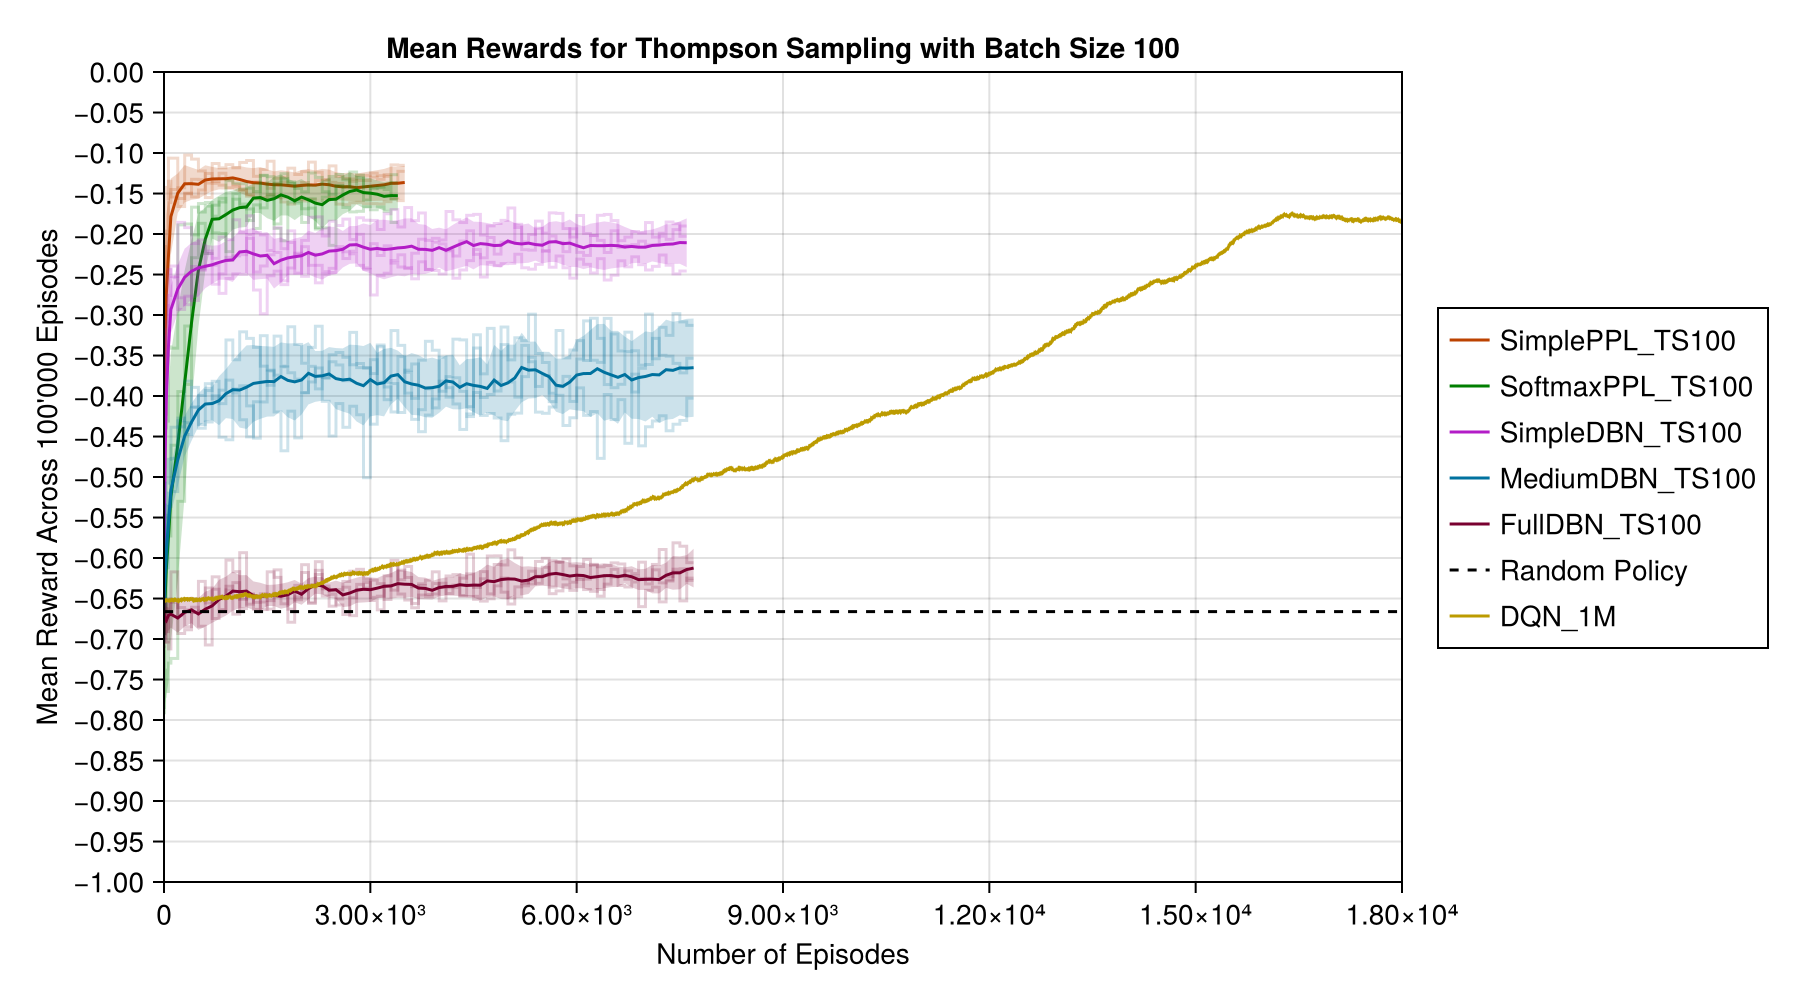

In [19]:
fig, ax = plot_mean_rewards(means, 100, [:SimplePPL100, :Softmax100, :Simple100, :Medium100, :None100], 18000)
# lines!(ax, 1:length(dqn[:long].mean_rewards), dqn[:long].mean_rewards, color=(colors_dict[:DQN], 0.1))
smoothed = moving_avg(dqn[:long].mean_rewards, 1000)
lines!(ax, 1:length(smoothed), smoothed, color=(colors_dict[:long]),label="DQN_1M")
# lines!(ax, 1:length(dqn[:medium].mean_rewards), dqn[:medium].mean_rewards, color=(colors_dict[:DQN], 0.1))
# smoothed = moving_avg(dqn[:medium].mean_rewards, 500)
# lines!(ax, 1:length(smoothed), smoothed, color=(colors_dict[:medium]),label="DQN_35000")
# lines!(ax, 1:length(dqn[:short].mean_rewards), dqn[:short].mean_rewards, color=(colors_dict[:DQN], 0.1))
# smoothed = moving_avg(dqn[:short].mean_rewards, 100)
# lines!(ax, 1:length(smoothed), smoothed, color=(colors_dict[:short]),label="DQN_5000")
Legend(fig[1, 2], ax, position = :right)
save("plots/ts100DQN1M.png", fig)
fig

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/Y3ABD/src/scenes.jl:238


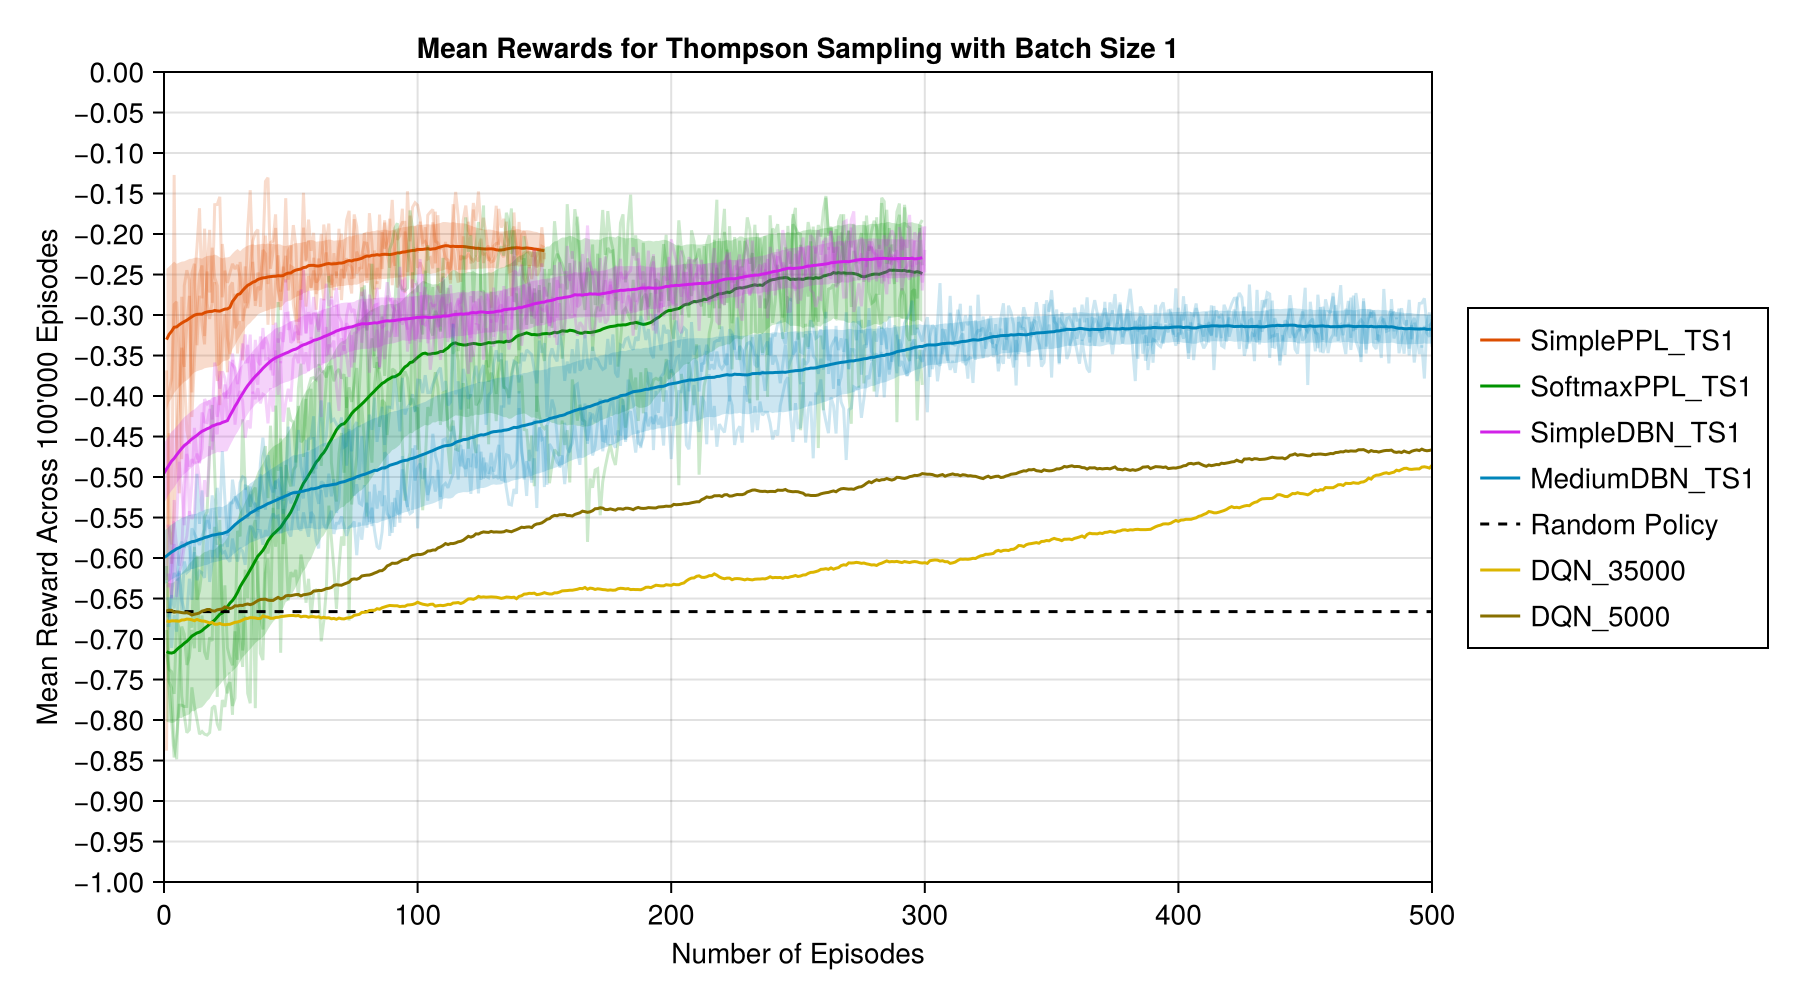

In [17]:
means_1 = calculate_mean_rewards(ts1, 1, 50)

fig, ax = plot_mean_rewards(means_1, 1, [:SimplePPL1, :Softmax1, :Simple1, :Medium1], 500)
# lines!(ax, 1:length(dqn[:long].mean_rewards), dqn[:long].mean_rewards, color=(colors_dict[:DQN], 0.1))
# smoothed = moving_avg(dqn[:long].mean_rewards, 100)
# lines!(ax, 1:length(smoothed), smoothed, color=(colors_dict[:long]),label="DQN_1M")
# # lines!(ax, 1:length(dqn[:medium].mean_rewards), dqn[:medium].mean_rewards, color=(colors_dict[:DQN], 0.1))
smoothed = moving_avg(dqn[:medium].mean_rewards, 100)
lines!(ax, 1:length(smoothed), smoothed, color=(colors_dict[:medium]),label="DQN_35000")
# lines!(ax, 1:length(dqn[:short].mean_rewards), dqn[:short].mean_rewards, color=(colors_dict[:DQN], 0.1))
smoothed = moving_avg(dqn[:short].mean_rewards, 100)
lines!(ax, 1:length(smoothed), smoothed, color=(colors_dict[:short]),label="DQN_5000")
Legend(fig[1, 2], ax, position = :right)
save("plots/ts1.png", fig)
fig

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/Y3ABD/src/scenes.jl:238


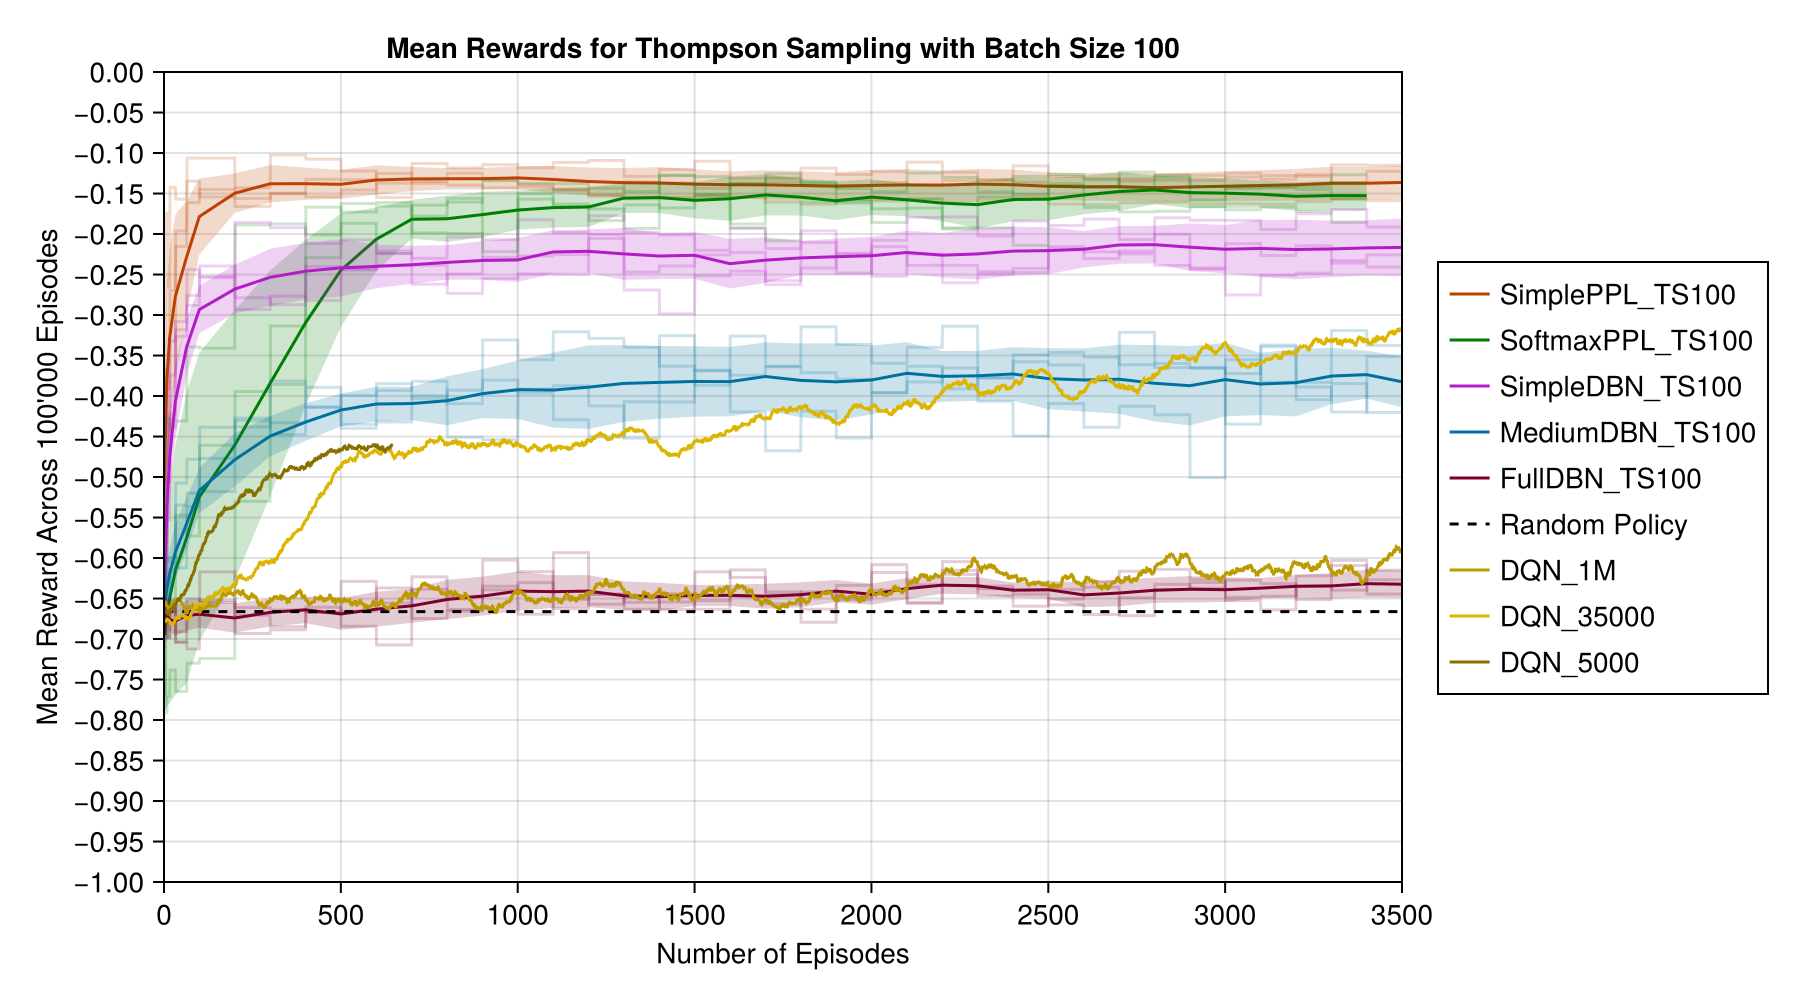

In [18]:
fig, ax = plot_mean_rewards(means, 100, [:SimplePPL100, :Softmax100, :Simple100, :Medium100, :None100],  3500)
# lines!(ax, 1:length(dqn[:long].mean_rewards), dqn[:long].mean_rewards, color=(colors_dict[:DQN], 0.1))
smoothed = moving_avg(dqn[:long].mean_rewards, 100)
lines!(ax, 1:length(smoothed), smoothed, color=(colors_dict[:long]),label="DQN_1M")
# lines!(ax, 1:length(dqn[:medium].mean_rewards), dqn[:medium].mean_rewards, color=(colors_dict[:DQN], 0.1))
smoothed = moving_avg(dqn[:medium].mean_rewards, 100)
lines!(ax, 1:length(smoothed), smoothed, color=(colors_dict[:medium]),label="DQN_35000")
# lines!(ax, 1:length(dqn[:short].mean_rewards), dqn[:short].mean_rewards, color=(colors_dict[:DQN], 0.1))
smoothed = moving_avg(dqn[:short].mean_rewards, 100)
lines!(ax, 1:length(smoothed), smoothed, color=(colors_dict[:short]),label="DQN_5000")
Legend(fig[1, 2], ax, position = :right)
save("plots/ts100.png", fig)
fig

In [22]:
type_labels = Dict(
    :Softmax => "\\mathsf{SoftmaxPPL}",
    :None => "\\mathsf{FullDBN}",
    :Medium => "\\mathsf{MediumDBN}",
    :DQN => "\\mathsf{DQN}",
    :SmoothedDQN => "\\mathsf{DQN}",
    :Simple => "\\mathsf{SimpleDBN}",
    :SimplePPL => "\\mathsf{SimplePPL}",
    :Softmax100 => "\\mathsf{SoftmaxPPL\\_100}",
    :None100 => "\\mathsf{FullDBN\\_100}",
    :Medium100 => "\\mathsf{MediumDBN\\_100}",
    :SmoothedDQN100 => "\\mathsf{DQN\\_100}",
    :Simple100 => "\\mathsf{SimpleDBN\\_100}",
    :SimplePPL100 => "\\mathsf{SimplePPL\\_100}",
    :Softmax1 => "\\mathsf{SoftmaxPPL\\_1}",
    :Medium1 => "\\mathsf{MediumDBN\\_1}",
    :SmoothedDQN1 => "\\mathsf{DQN\\_1}",
    :Simple1 => "\\mathsf{SimpleDBN\\_1}",
    :SimplePPL1 => "\\mathsf{SimplePPL\\_0}",
    :long => "\\mathsf{DQN\\_1M}",
    :medium => "\\mathsf{DQN\\_35000}",
    :short => "\\mathsf{DQN\\_5000}",
)

Dict{Symbol, String} with 21 entries:
  :long           => "\\mathsf{DQN\\_1M}"
  :Softmax1       => "\\mathsf{SoftmaxPPL\\_1}"
  :short          => "\\mathsf{DQN\\_5000}"
  :SmoothedDQN1   => "\\mathsf{DQN\\_1}"
  :SimplePPL100   => "\\mathsf{SimplePPL\\_100}"
  :medium         => "\\mathsf{DQN\\_35000}"
  :Medium100      => "\\mathsf{MediumDBN\\_100}"
  :Medium         => "\\mathsf{MediumDBN}"
  :None100        => "\\mathsf{FullDBN\\_100}"
  :DQN            => "\\mathsf{DQN}"
  :SimplePPL      => "\\mathsf{SimplePPL}"
  :SmoothedDQN100 => "\\mathsf{DQN\\_100}"
  :Simple100      => "\\mathsf{SimpleDBN\\_100}"
  :Softmax        => "\\mathsf{SoftmaxPPL}"
  :None           => "\\mathsf{FullDBN}"
  :Medium1        => "\\mathsf{MediumDBN\\_1}"
  :SmoothedDQN    => "\\mathsf{DQN}"
  :Simple1        => "\\mathsf{SimpleDBN\\_1}"
  :SimplePPL1     => "\\mathsf{SimplePPL\\_0}"
  :Softmax100     => "\\mathsf{SoftmaxPPL\\_100}"
  :Simple         => "\\mathsf{SimpleDBN}"

In [11]:
function generate_latex_table(cumsums, checkpoints, type_labels, types)
    table = "\\begin{tabular}{|l|" * "r|"^length(checkpoints) * "}\n\\hline\n"
    table *= " & " * join(["\$" * string(ch) * "\$" for ch in checkpoints], " & ") * " \\\\ \\hline\n"

    # Collect all column values to compute min and max later
    column_values = [Float64[] for _ in checkpoints]

    for (_, values) in cumsums
        for (j, checkpoint) in enumerate(checkpoints)
            if checkpoint <= length(values)
                push!(column_values[j], round(values[checkpoint], digits=2))
            else
                push!(column_values[j], NaN)
            end
        end
    end

    # Identify min and max for each column
    column_mins = [isempty(col[.!isnan.(col)]) ? NaN : minimum(col[.!isnan.(col)]) for col in column_values]
    column_maxs = [isempty(col[.!isnan.(col)]) ? NaN : maximum(col[.!isnan.(col)]) for col in column_values]


    for key in types
        label = type_labels[key]
        # Generate row data, only include values where checkpoints are valid
        row_data = []
        for (j, checkpoint) in enumerate(checkpoints)
            if checkpoint <= length(cumsums[key])
                value = round(cumsums[key][checkpoint], digits=2)
                if value == column_mins[j]
                    push!(row_data, "\\color{red}{\$" * string(value) * "\$}")
                elseif value == column_maxs[j]
                    push!(row_data, "\\color{blue}{\$" * string(value) * "\$}")
                else
                    push!(row_data, "\$" * string(value) * "\$")
                end
            else
                push!(row_data, "-")
            end
        end
        table *= "\$" * label * "\$ & " * join(row_data, " & ") * " \\\\ \n"
    end

    table *= "\\hline \n\\end{tabular}\n"
    return table
end


generate_latex_table (generic function with 1 method)

In [79]:
cumsums = Dict(type => accumulate(.+, mean_rewards_35000[type]) for type in keys(mean_rewards_35000))

Dict{Symbol, Vector{Float64}} with 7 entries:
  :Simple      => [-0.671597, -1.29913, -1.91744, -2.53576, -3.12072, -3.70567,…
  :Softmax     => [-0.66947, -1.35843, -2.07689, -2.79535, -3.50602, -4.21669, …
  :None        => [-0.658183, -1.33245, -2.0012, -2.66994, -3.34516, -4.02037, …
  :SmoothedDQN => [-0.6574, -1.31505, -1.9726, -2.6302, -3.28765, -3.94485, -4.…
  :Medium      => [-0.671667, -1.31356, -1.95807, -2.60258, -3.25684, -3.9111, …
  :DQN         => [-0.56, -1.2, -1.88, -2.58, -3.34, -4.0, -4.74, -5.5, -6.12, …
  :SimplePPL   => [-0.624323, -1.07733, -1.46437, -1.85141, -2.2319, -2.61239, …

In [31]:
mean_rewards_every

Dict{Any, Any} with 6 entries:
  :DQN         => [-0.633333, -0.766667, -0.733333, -0.533333, -0.7, -0.4, -0.7…
  :Softmax     => [-0.67245, -0.750493, -0.7667, -0.81518, -0.780507, -0.73752,…
  :SmoothedDQN => [-0.6524, -0.652467, -0.652333, -0.652233, -0.652367, -0.6522…
  :Medium      => [-0.668417, -0.668417, -0.666513, -0.650337, -0.65212, -0.607…
  :SimplePPL   => [-0.611203, -0.467777, -0.522927, -0.32263, -0.39457, -0.4196…
  :Simple      => [-0.60532, -0.60532, -0.634067, -0.55527, -0.596587, -0.56922…

In [78]:
cumsums_every = Dict(type => accumulate(.+, mean_rewards_every[type]) for type in keys(mean_rewards_every))


Dict{Symbol, Vector{Float64}} with 6 entries:
  :Simple      => [-0.60532, -1.21064, -1.84471, -2.39998, -2.99656, -3.56579, …
  :Softmax     => [-0.67245, -1.42294, -2.18964, -3.00482, -3.78533, -4.52285, …
  :SmoothedDQN => [-0.63, -1.258, -1.892, -2.535, -3.184, -3.837, -4.5, -5.161,…
  :Medium      => [-0.668417, -1.33683, -2.00335, -2.65368, -3.3058, -3.91295, …
  :DQN         => [-0.68, -1.3, -1.84, -2.48, -3.12, -3.7, -4.36, -5.1, -5.72, …
  :SimplePPL   => [-0.611203, -1.07898, -1.60191, -1.92454, -2.31911, -2.73879,…

In [80]:
print(generate_latex_table(cumsums, [10,100,150,400,1000,3000], type_labels, [:SimplePPL, :Softmax, :Simple, :Medium, :None, :DQN]))

\begin{tabular}{|l|r|r|r|r|r|r|}
\hline
 & $10$ & $100$ & $150$ & $400$ & $1000$ & $3000$ \\ \hline
$\mathsf{SimplePPL}$ & \color{blue}{$-4.18$} & \color{blue}{$-21.95$} & \color{blue}{$-28.71$} & \color{blue}{$-64.39$} & \color{blue}{$-143.44$} & \color{blue}{$-422.4$} \\ 
$\mathsf{SoftmaxPPL}$ & \color{red}{$-6.89$} & $-58.76$ & $-84.19$ & $-176.29$ & $-286.8$ & $-596.63$ \\ 
$\mathsf{SimpleDBN}$ & $-5.84$ & $-34.65$ & $-47.08$ & $-109.97$ & $-251.98$ & $-697.91$ \\ 
$\mathsf{MediumDBN}$ & $-6.49$ & $-56.14$ & $-80.03$ & $-189.2$ & $-432.69$ & $-1194.96$ \\ 
$\mathsf{FullDBN}$ & $-6.74$ & \color{red}{$-68.02$} & \color{red}{$-100.08$} & \color{red}{$-267.57$} & \color{red}{$-659.67$} & \color{red}{$-1942.7$} \\ 
$\mathsf{DQN}$ & $-6.8$ & $-67.1$ & $-99.48$ & $-251.28$ & $-535.2$ & $-1362.92$ \\ 
\hline 
\end{tabular}


In [81]:
print(generate_latex_table(cumsums_every, [10,100, 150, 400], type_labels, [:SimplePPL, :Softmax, :Simple, :Medium, :DQN]))


\begin{tabular}{|l|r|r|r|r|}
\hline
 & $10$ & $100$ & $150$ & $400$ \\ \hline
$\mathsf{SimplePPL}$ & \color{blue}{$-4.1$} & \color{blue}{$-26.12$} & \color{blue}{$-37.04$} & - \\ 
$\mathsf{SoftmaxPPL}$ & \color{red}{$-7.54$} & $-53.56$ & $-70.35$ & - \\ 
$\mathsf{SimpleDBN}$ & $-5.72$ & $-37.16$ & $-51.97$ & - \\ 
$\mathsf{MediumDBN}$ & $-6.4$ & $-53.47$ & $-75.86$ & \color{blue}{$-164.83$} \\ 
$\mathsf{DQN}$ & $-6.3$ & $-64.58$ & \color{red}{$-92.84$} & $-220.86$ \\ 
\hline 
\end{tabular}


In [17]:
mean_rewards_every

Dict{Any, Any} with 6 entries:
  :DQN         => [-0.633333, -0.766667, -0.733333, -0.533333, -0.7, -0.4, -0.7…
  :Softmax     => [-0.67245, -0.750493, -0.7667, -0.81518, -0.780507, -0.73752,…
  :SmoothedDQN => [-0.6524, -0.652467, -0.652333, -0.652233, -0.652367, -0.6522…
  :Medium      => [-0.668417, -0.668417, -0.666513, -0.650337, -0.65212, -0.607…
  :SimplePPL   => [-0.611203, -0.467777, -0.522927, -0.32263, -0.39457, -0.4196…
  :Simple      => [-0.60532, -0.60532, -0.634067, -0.55527, -0.596587, -0.56922…

In [82]:
function calculate_and_generate_sample_efficiency_table(mean_rewards, thresholds, types)
    # Calculate sample efficiency
    sample_efficiency = Dict{Symbol, Dict{Float64, Int}}()
    
    for (type, rewards) in mean_rewards
        type_efficiency = Dict{Float64, Int}()

        for threshold in thresholds
            # Find the first index where the cumulative reward reaches or exceeds the threshold
            index = findfirst(x -> x >= threshold, rewards)

            if isnothing(index)
                continue
            else
                type_efficiency[threshold] = index
            end
        end

        sample_efficiency[type] = type_efficiency
    end

    # Generate LaTeX table
    table = "\\begin{tabular}{|l|" * "r|"^length(thresholds) * "}\n\\hline\n"
    table *= " & " * join(["\$" * string(th) * "\$" for th in thresholds], " & ") * " \\\\ \\hline\n"

    # Collect all column values to compute min and max later
    column_values = [Float64[] for _ in thresholds]

    for (_, values) in sample_efficiency
        for (j, threshold) in enumerate(thresholds)
            if haskey(values, threshold)
                push!(column_values[j], values[threshold])
            else
                push!(column_values[j], NaN)
            end
        end
    end

    # Identify min and max for each column
    column_mins = [isempty(col[.!isnan.(col)]) ? NaN : minimum(col[.!isnan.(col)]) for col in column_values]
    column_maxs = [isempty(col[.!isnan.(col)]) ? NaN : maximum(col[.!isnan.(col)]) for col in column_values]

    # Generate table rows
    for key in types
        label = type_labels[key]
        row_data = []
        for (j, threshold) in enumerate(thresholds)
            if haskey(sample_efficiency[key], threshold)
                value = sample_efficiency[key][threshold]
                if value == column_mins[j]
                    push!(row_data, "\\color{blue}{\$" * string(value) * "\$}")
                elseif value == column_maxs[j]
                    push!(row_data, "\\color{red}{\$" * string(value) * "\$}")
                else
                    push!(row_data, "\$" * string(value) * "\$")
                end
            else
                push!(row_data, "-")
            end
        end
        table *= "\$" * label * "\$ & " * join(row_data, " & ") * " \\\\ \n"
    end

    table *= "\\hline \\end{tabular}\n"
    return table
end


calculate_and_generate_sample_efficiency_table (generic function with 1 method)

In [83]:

thresholds = [-0.6, -0.5, -0.4, -0.3, -0.2, -0.1]

latex_table = calculate_and_generate_sample_efficiency_table(mean_rewards_35000, thresholds, [:SimplePPL, :Softmax, :Simple, :Medium, :None, :DQN])
println(latex_table)


\begin{tabular}{|l|r|r|r|r|r|r|}
\hline
 & $-0.6$ & $-0.5$ & $-0.4$ & $-0.3$ & $-0.2$ & $-0.1$ \\ \hline
$\mathsf{SimplePPL}$ & $2$ & \color{blue}{$2$} & \color{blue}{$3$} & \color{blue}{$17$} & \color{blue}{$33$} & - \\ 
$\mathsf{SoftmaxPPL}$ & $33$ & $201$ & $201$ & $301$ & $401$ & - \\ 
$\mathsf{SimpleDBN}$ & $5$ & $9$ & $17$ & $65$ & $1201$ & - \\ 
$\mathsf{MediumDBN}$ & $33$ & $101$ & $701$ & - & - & - \\ 
$\mathsf{FullDBN}$ & - & - & - & - & - & - \\ 
$\mathsf{DQN}$ & \color{blue}{$1$} & $124$ & $363$ & $732$ & \color{red}{$1988$} & \color{blue}{$3121$} \\ 
\hline \end{tabular}



In [84]:

latex_table = calculate_and_generate_sample_efficiency_table(mean_rewards_every, thresholds, [:SimplePPL, :Softmax, :Simple, :Medium, :DQN])
println(latex_table)


\begin{tabular}{|l|r|r|r|r|r|r|}
\hline
 & $-0.6$ & $-0.5$ & $-0.4$ & $-0.3$ & $-0.2$ & $-0.1$ \\ \hline
$\mathsf{SimplePPL}$ & \color{blue}{$2$} & \color{blue}{$2$} & \color{blue}{$4$} & \color{blue}{$12$} & \color{blue}{$40$} & - \\ 
$\mathsf{SoftmaxPPL}$ & $35$ & $45$ & $65$ & $90$ & \color{red}{$248$} & - \\ 
$\mathsf{SimpleDBN}$ & $4$ & $12$ & $20$ & $55$ & - & - \\ 
$\mathsf{MediumDBN}$ & $12$ & $59$ & $140$ & $349$ & - & - \\ 
$\mathsf{DQN}$ & $3$ & $45$ & \color{red}{$172$} & \color{red}{$569$} & - & - \\ 
\hline \end{tabular}



In [21]:
mean_rewards[:SmoothedDQN]


140172-element Vector{Float64}:
 -0.6515000050365924
 -0.651533338367939
 -0.6514833383858204
 -0.6514500050544739
 -0.6515166717171669
 -0.6515166717171669
 -0.6517166717201471
 -0.6516666717380285
 -0.6516666717380285
 -0.6516000050753356
 -0.6516833384186029
 -0.651750005081296
 -0.651766671732068
  ⋮
 -0.1401833371836692
 -0.1399333371799439
 -0.13991667050682008
 -0.13995000384189188
 -0.1400666705109179
 -0.140050003843382
 -0.14003333717770874
 -0.14003333717770874
 -0.13996667051129044
 -0.13996667051129044
 -0.14010000384785234
 -0.14003333717770874

In [22]:
mean_rewards_every[:SmoothedDQN]

140172-element Vector{Float64}:
 -0.6524000055193901
 -0.6524666721820831
 -0.6523333388566971
 -0.6522333388328552
 -0.6523666721582413
 -0.652266672194004
 -0.6525333388745784
 -0.6524000055491924
 -0.6524000055491924
 -0.6525666722357273
 -0.6524666722714901
 -0.6525666722953319
 -0.6525666722953319
  ⋮
 -0.14196667068824173
 -0.1417000040151179
 -0.1416333373375237
 -0.14150000400468707
 -0.1417000040076673
 -0.1414666706621647
 -0.14170000400021673
 -0.1416333373375237
 -0.14196667067334057
 -0.14203333733603357
 -0.1422666706778109
 -0.1421333373375237

In [85]:
function convergence(mean_rewards, checkpoints, types, last_n)
    # Calculate asymptotic mean rewards and convergence speeds for each checkpoint
    asymptotic_rewards = Dict{Symbol, Float64}()
    convergence_speeds = Dict{Symbol, Dict{Float64, Int}}()
    lengths = Dict{Symbol, Int}()

    for (type, rewards) in mean_rewards
        # Store the length of the rewards array
        lengths[type] = length(rewards)

        # Asymptotic mean reward
        if !isempty(rewards)
            asymptotic_rewards[type] = mean(rewards[end-last_n:end])
        else
            asymptotic_rewards[type] = NaN
        end

        # Convergence speed for each checkpoint
        convergence_speeds[type] = Dict()
        for checkpoint in checkpoints
            min_reward = minimum(rewards)
            max_reward = maximum(rewards)
            reward_range = max_reward - min_reward

            if reward_range == 0
                convergence_speeds[type][checkpoint] = -1  # No valid range for convergence
                continue
            end

            threshold_value = min_reward + checkpoint * reward_range
            index = findfirst(x -> x >= threshold_value, rewards)
            if isnothing(index)
                convergence_speeds[type][checkpoint] = -1  # Indicate no convergence
            else
                convergence_speeds[type][checkpoint] = index
            end
        end
    end

    # Generate LaTeX table
    table = "\\begin{tabular}{|l|" * repeat("r|", length(checkpoints) + 2) * "}\\hline\n"
    table *= " & Asympt. Rew. " * join(["& $(Int(round(cp*100, digits=0)))\\%" for cp in checkpoints]) * " & Nr. Ep. \\\\ \\hline\n"

    # Identify min and max for highlighting across checkpoints
    all_asymptotic_values = collect(values(asymptotic_rewards))
    valid_asymptotic_values = all_asymptotic_values[.!isnan.(all_asymptotic_values)]
    min_asymptotic = isempty(valid_asymptotic_values) ? NaN : minimum(valid_asymptotic_values)
    max_asymptotic = isempty(valid_asymptotic_values) ? NaN : maximum(valid_asymptotic_values)

    for type in types
        label = type_labels[type]
        asymptotic = asymptotic_rewards[type]
        length = lengths[type]

        # Asymptotic mean reward formatting
        if isnan(asymptotic)
            asymptotic_cell = "-"
        elseif asymptotic == min_asymptotic
            asymptotic_cell = "\\color{red}{\$" * string(round(asymptotic, digits=2)) * "\$}"
        elseif asymptotic == max_asymptotic
            asymptotic_cell = "\\color{blue}{\$" * string(round(asymptotic, digits=2)) * "\$}"
        else
            asymptotic_cell = "\$" * string(round(asymptotic, digits=2)) * "\$"
        end

        # Convergence speed formatting for each checkpoint
        convergence_cells = []
        for checkpoint in checkpoints
            convergence = convergence_speeds[type][checkpoint]
            all_convergence_values = [convergence_speeds[t][checkpoint] for t in types if convergence_speeds[t][checkpoint] >= 0]
            min_convergence = isempty(all_convergence_values) ? NaN : minimum(all_convergence_values)
            max_convergence = isempty(all_convergence_values) ? NaN : maximum(all_convergence_values)

            if convergence == -1
                push!(convergence_cells, "-")
            elseif convergence == min_convergence
                push!(convergence_cells, "\\color{blue}{\$" * string(convergence) * "\$}")
            elseif convergence == max_convergence
                push!(convergence_cells, "\\color{red}{\$" * string(convergence) * "\$}")
            else
                push!(convergence_cells, "\$" * string(convergence) * "\$")
            end
        end

        table *= "\$" * label * "\$ & " * asymptotic_cell * " & " * join(convergence_cells, " & ") * " & \$" * string(length) * "\$ \\\\ \n"
    end

    table *= "\\hline\\end{tabular}\n"
    return table
end


convergence (generic function with 1 method)

In [86]:

latex_table = convergence(mean_rewards, [0.6,0.7,0.8,0.9,0.99], [:SimplePPL, :Softmax, :Simple, :Medium, :None, :SmoothedDQN], 10)
println(latex_table)


\begin{tabular}{|l|r|r|r|r|r|r|r|}\hline
 & Asympt. Rew. & 60\%& 70\%& 80\%& 90\%& 99\% & Nr. Ep. \\ \hline
$\mathsf{SimplePPL}$ & \color{blue}{$-0.13$} & \color{blue}{$17$} & \color{blue}{$33$} & \color{blue}{$33$} & \color{blue}{$65$} & \color{blue}{$401$} & $3500$ \\ 
$\mathsf{SoftmaxPPL}$ & $-0.16$ & $301$ & $301$ & $401$ & $501$ & $1401$ & $3400$ \\ 
$\mathsf{SimpleDBN}$ & $-0.21$ & \color{blue}{$17$} & \color{blue}{$33$} & $65$ & $501$ & $1201$ & $7600$ \\ 
$\mathsf{MediumDBN}$ & $-0.36$ & $201$ & $201$ & $701$ & $1401$ & $5301$ & $7700$ \\ 
$\mathsf{FullDBN}$ & \color{red}{$-0.62$} & $101$ & $901$ & $2001$ & $2201$ & $7401$ & $7700$ \\ 
$\mathsf{DQN}$ & $-0.14$ & \color{red}{$12914$} & \color{red}{$13961$} & \color{red}{$15240$} & \color{red}{$16589$} & \color{red}{$98994$} & $140172$ \\ 
\hline\end{tabular}



In [88]:

latex_table = convergence(mean_rewards_35000, [0.6,0.7,0.8,0.9,0.99], [:SimplePPL, :Softmax, :Simple, :Medium, :None, :SmoothedDQN], 10)
println(latex_table)


\begin{tabular}{|l|r|r|r|r|r|r|r|}\hline
 & Asympt. Rew. & 60\%& 70\%& 80\%& 90\%& 99\% & Nr. Ep. \\ \hline
$\mathsf{SimplePPL}$ & \color{blue}{$-0.13$} & \color{blue}{$17$} & \color{blue}{$33$} & \color{blue}{$33$} & \color{blue}{$65$} & \color{blue}{$401$} & $3500$ \\ 
$\mathsf{SoftmaxPPL}$ & $-0.16$ & $301$ & $301$ & $401$ & $501$ & $1401$ & $3400$ \\ 
$\mathsf{SimpleDBN}$ & $-0.21$ & \color{blue}{$17$} & \color{blue}{$33$} & $65$ & $501$ & $1201$ & $7600$ \\ 
$\mathsf{MediumDBN}$ & $-0.36$ & $201$ & $201$ & $701$ & $1401$ & $5301$ & $7700$ \\ 
$\mathsf{FullDBN}$ & \color{red}{$-0.62$} & $101$ & $901$ & $2001$ & $2201$ & \color{red}{$7401$} & $7700$ \\ 
$\mathsf{DQN}$ & $-0.29$ & \color{red}{$1642$} & \color{red}{$2217$} & \color{red}{$2844$} & \color{red}{$3419$} & $4361$ & $4590$ \\ 
\hline\end{tabular}



In [89]:

latex_table = convergence(mean_rewards_every, [0.6,0.7,0.8,0.9,0.99], [:SimplePPL, :Softmax, :Simple, :Medium, :SmoothedDQN], 10)
println(latex_table)

\begin{tabular}{|l|r|r|r|r|r|r|r|}\hline
 & Asympt. Rew. & 60\%& 70\%& 80\%& 90\%& 99\% & Nr. Ep. \\ \hline
$\mathsf{SimplePPL}$ & $-0.23$ & \color{blue}{$4$} & \color{blue}{$12$} & \color{blue}{$14$} & \color{blue}{$20$} & \color{blue}{$40$} & $150$ \\ 
$\mathsf{SoftmaxPPL}$ & $-0.27$ & $45$ & $78$ & $90$ & $217$ & $248$ & $299$ \\ 
$\mathsf{SimpleDBN}$ & \color{blue}{$-0.23$} & $27$ & $48$ & $79$ & $138$ & $271$ & $300$ \\ 
$\mathsf{MediumDBN}$ & $-0.28$ & $114$ & $181$ & $205$ & $339$ & \color{red}{$750$} & $925$ \\ 
$\mathsf{DQN}$ & $-0.45$ & \color{red}{$163$} & \color{red}{$203$} & \color{red}{$260$} & \color{red}{$428$} & $632$ & $646$ \\ 
\hline\end{tabular}



In [26]:
medium = ts[:Medium][1]

PyObject <custom_sepsis.models.dirichlet.evaluate.thompson_sampling.DirThompsonSampling object at 0x3254bafb0>

In [27]:
exploration_data = Dict(vs=> [] for vs in ["HR", "BP", "O2", "GLU"])
iterations = collect(keys(medium.models))
inp_vals = [sepsis_gym.HR_STATES, sepsis_gym.BP_STATES, sepsis_gym.O2_STATES, sepsis_gym.GLU_STATES]
values = [[sepsis_gym.Level.LOW.value, sepsis_gym.Level.NORMAL.value, sepsis_gym.Level.HIGH.value],
          [sepsis_gym.Level.LOW.value, sepsis_gym.Level.NORMAL.value, sepsis_gym.Level.HIGH.value],
            [sepsis_gym.Level.LOW.value, sepsis_gym.Level.NORMAL.value,],
            [sepsis_gym.Level.SUPER_LOW.value, sepsis_gym.Level.LOW.value, sepsis_gym.Level.NORMAL.value, sepsis_gym.Level.HIGH.value, sepsis_gym.Level.SUPER_HIGH.value]]

for iteration in iterations
    for (i, vs) in enumerate(["HR", "BP", "O2", "GLU"])
        state_vals = values[i]
        exploration_per_input = Dict()
        for state in inp_vals[i]
            for action in sepsis_gym.ACTIONS
                exploration_per_input[(state, action)] = sum([medium.models[iteration][i][(state, action, next_s)] for next_s in state_vals]) / length(state_vals)
            end
        end

        flat = collect(values(exploration_per_input))
        # incorporate sums
        explored_percentage = length(filter(x -> x > 1, flat)) / length(flat) * 100
        push!(exploration_data[vs], explored_percentage)
    end
end



# plt.figure(figsize=(7, 4))

# for vs in ["HR", "BP", "O2", "GLU"]:
#     plt.plot(iterations, exploration_data[vs], label=f"{vs} Count Exploration %")

# plt.xlabel("Nr Episodes in History")
# plt.ylabel("Exploration Percentage (%)")
# plt.title("Exploration Percentage Growth Over Nr Episodes in History")
# plt.legend()
# plt.xscale("log", base=10)
# plt.grid(True)

# plt.show()


LoadError: cannot assign a value to imported variable Base.values from module Main